## Goal 

* Predict total sales for every product and store in the next month.
* The task is to forecast the total amount of products sold in every shop for the test set. 

* Note that the list of shops and products slightly changes every month. 

* Creating a robust model that can handle such situations is part of the challenge.

## Columns info

* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
!ls

item_categories.csv   sample_submission.csv test.csv
items.csv             shops.csv
sales_train.csv       starting.ipynb


In [5]:
train = pd.read_csv('sales_train.csv')
item = pd.read_csv('items.csv')
item_category = pd.read_csv('item_categories.csv')
shop = pd.read_csv('shops.csv')
sample_submission = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')

In [8]:
train.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0


In [14]:
train['date_block_num'].min(),train['date_block_num'].max()

(0, 33)

In [9]:
item.head(2)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76


In [10]:
item_category.head(2)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1


In [11]:
shop.head(2)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1


In [13]:
test.head(2)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320


In [12]:
sample_submission.head(2)

,ID,item_cnt_month
0,0,0.5
1,1,0.5


## Preparation of  Training data

In [18]:
train['date'] = pd.to_datetime(train['date'],format='%d.%m.%Y')
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [38]:
train['month'] = train.date.dt.month
train['year'] = train.date.dt.year

In [39]:
train.index = train.date

In [40]:
train.groupby(pd.Grouper(freq='M'))['item_cnt_day'].count().head()

date
2013-01-31    115690
2013-02-28    108613
2013-03-31    121347
2013-04-30     94109
2013-05-31     91759
Freq: M, Name: item_cnt_day, dtype: int64

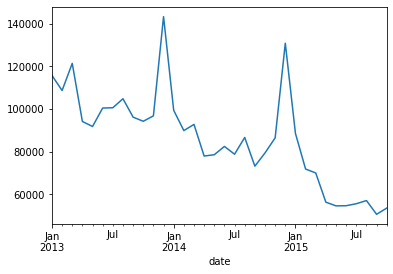

In [41]:
train.groupby(pd.Grouper(freq='M'))['item_cnt_day'].count().plot()

In [42]:
train_prepared = pd.DataFrame(train.groupby(['year','month','shop_id','item_id'])['item_cnt_day'].sum()).reset_index()

In [43]:
train_prepared = train_prepared.rename(columns={'item_cnt_day':'item_cnt_month'})

In [44]:
train_prepared.head(3)

,year,month,shop_id,item_id,item_cnt_month
0,2013,1,0,32,6.0
1,2013,1,0,33,3.0
2,2013,1,0,35,1.0


In [45]:
y = train_prepared['item_cnt_month']
X = train_prepared.drop(['item_cnt_month'],axis=1)

In [48]:
from sklearn.model_selection import train_test_split

In [51]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state = 2)

In [53]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1206843, 4), (402281, 4), (1206843,), (402281,))

## Intial Model

### Linear Regression

In [82]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

In [83]:
reg.score(X_test, y_test)

0.0004131618079992183

In [84]:
reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [85]:
from sklearn.metrics import mean_squared_error

In [86]:
mean_squared_error(y,reg.predict(X))

74.78881238051919

In [87]:
X.tail()

,year,month,shop_id,item_id
1609119,2015,10,59,22087
1609120,2015,10,59,22088
1609121,2015,10,59,22091
1609122,2015,10,59,22100
1609123,2015,10,59,22102


In [88]:
#y_pred = reg.predict(X_test)

In [89]:
test['year'] = 2015
test['month'] = 11

In [90]:
test.head(2)

,ID,shop_id,item_id,year,month,item_cnt_month
0,0,5,5037,2015,11,2.533567
1,1,5,5320,2015,11,2.529233


In [91]:
y_ = reg.predict(test[['year','month','shop_id','item_id']])

In [92]:
test['item_cnt_month'] = y_

In [93]:
test['item_cnt_month'].min()

2.270962641893476

In [94]:
test['item_cnt_month'].max()

2.615244980538023

In [95]:
test[['ID','item_cnt_month']].to_csv('1st.csv',index=False)

* Score : 2.47948

## After normalise the data

In [99]:
from sklearn.preprocessing import StandardScaler

In [100]:
std_scale = StandardScaler().fit(X)
X_train_std = std_scale.transform(X)
X_test_std  = std_scale.transform(test[['year','month','shop_id','item_id']])

In [101]:
reg.fit(X_train_std,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [103]:
mean_squared_error(y,reg.predict(X_train_std))

74.78881238051919

In [104]:
y_ = reg.predict(X_test_std)

In [105]:
test['item_cnt_month'] = y_

In [106]:
test['item_cnt_month'].min()

2.270962641893449

In [107]:
test['item_cnt_month'].max()

2.615244980538042

In [108]:
test[['ID','item_cnt_month']].to_csv('2nd.csv',index=False)

* Score : 2.47948

* Rank : 5038

## Decision Tree Regressor

In [109]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=0)

In [110]:
regressor.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=0, splitter='best')

In [122]:
mean_squared_error(y,regressor.predict(X))

0.0

In [111]:
regressor.predict(test[['year','month','shop_id','item_id']])

array([1., 5., 1., ..., 1., 1., 1.])

In [117]:
y_ = regressor.predict(test[['year','month','shop_id','item_id']])

In [118]:
test['item_cnt_month'] = y_.clip(0, 20) 

In [119]:
test['item_cnt_month'].min()

0.0

In [120]:
test['item_cnt_month'].max()

20.0

In [123]:
test[['ID','item_cnt_month']].to_csv('3rd.csv',index=False)

* Score : 2.34994
* Rank : 5009

## Gradient boosting regressor

In [126]:
from sklearn.ensemble import GradientBoostingRegressor
regressor = GradientBoostingRegressor()

In [127]:
regressor.fit(X,y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [128]:
mean_squared_error(y,regressor.predict(X))

53.73156323322391

In [129]:
regressor.predict(test[['year','month','shop_id','item_id']])

array([2.27106389, 2.27106389, 2.27106389, ..., 1.73569868, 1.56948272,
       1.59754202])

In [130]:
y_ = regressor.predict(test[['year','month','shop_id','item_id']])

In [131]:
test['item_cnt_month'] = y_.clip(0, 20) 

In [132]:
test['item_cnt_month'].min()

0.0

In [133]:
test['item_cnt_month'].max()

20.0

In [134]:
test[['ID','item_cnt_month']].to_csv('4th.csv',index=False)

* Score : 2.30092
* Rank : 4993